# Titanic Kaggle Challenge

**Description:** This Notebook generates a prediction file (my_submission) for the Kaggle Titanic Challenge.

**Input:** Titanic Passenger Data

**Output:** Submission of Predicted Survivors

**Sections:**

1.   Load the Titanic Data
2.   Prepare the Titanic Data
3.   Search for Best Model amongst: Random Forrest, Logistic Regression and Support Vector Machine Classifier
4.   Evaluate the best model 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
# Display Validation/Test Scores
def display_scores(scores):
  print("Scores", scores)
  print("Mean",scores.mean())
  print("Standard Deviation",scores.std())

In [3]:
# Save Submissions in a File
def SaveSubmission(predictions):
  output = pd.DataFrame({'PassengerId': test_data.PassengerId , 'Survived': predictions})
  output.to_csv ('titanic/my_submission.csv', index=False)
  print("Your submission was successfully saved")

# 1. Load the Data


In [4]:
train_data = pd.read_csv("titanic/train.csv")
test_data = pd.read_csv("titanic/test.csv")

y = train_data["Survived"]

# 2. Prepare Data

In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [9]:
# Survival Rate of Women
women = train_data.loc[train_data.Sex == 'female', 'Survived']
rate_women = sum(women) / len (women)
print("% of women who survived: ", rate_women)

% of women who survived:  0.7420382165605095


In [10]:
# Survival Rate of Men
men = train_data.loc[train_data.Sex == 'male', 'Survived']
rate_men = sum(men) / len (men)
print("% of men who survived: ", rate_men)

% of men who survived:  0.18890814558058924


In [11]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [12]:
# Convert Sex From Categorical to Value
train_data_pd = pd.get_dummies(train_data, columns=["Sex"])        # Convert categorical variable into dummy/indicator variables.
test_data_pd = pd.get_dummies(test_data, columns=["Sex"])        # Convert categorical variable into dummy/indicator variables.

In [13]:
# Passengers embarked at Southampton, Cherbourg and Queenstown, Iceland
train_data_pd["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [14]:
train_data_pd.loc[train_data.Embarked.isnull() == True]

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male
61,62,1,1,"Icard, Miss. Amelie",38.0,0,0,113572,80.0,B28,NaN,1,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",62.0,0,0,113572,80.0,B28,NaN,1,0


In [15]:
# PassengerId 62 and 830 boarded at Southhampton
# https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html
train_data_pd.Embarked.fillna(value='S', inplace=True)

train_data_pd.Embarked.isnull().values.any()

False

In [16]:
train_data_pd = pd.get_dummies(train_data_pd, columns=["Embarked"])
test_data_pd = pd.get_dummies(test_data_pd, columns=["Embarked"])

In [17]:
# Find if there is NULL values in the Fare column
test_data_pd.Fare.isnull().values.any()        # Option 1
test_data_pd['Fare'].isnull().values.any()     # Option 2

# Find where Fare has NULL value
test_data_pd.loc[test_data.Fare.isnull() == True]

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
152,1044,3,"Storey, Mr. Thomas",60.5,0,0,3701,NaN,NaN,0,1,0,0,1


In [18]:
# Fill test_data.Fare NULL
test_data_pd.Fare.fillna(value=0, inplace=True)
test_data_pd.loc[test_data.Fare.isnull() == True]

# Fill All the NULL/NAN Columns
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
# imputer.fit(test_data_pd)
# temp = imputer.transform(test_data_pd)
# test_data_pd = pd.DataFrame(temp, columns=test_data_pd.columns, index=test_data_pd.index)
# test_data_pd.loc[test_data_pd.PassengerId == 1044]

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
152,1044,3,"Storey, Mr. Thomas",60.5,0,0,3701,0.0,NaN,0,1,0,0,1


In [19]:
train_data_pd.drop(columns=["PassengerId", "Name", "Cabin", "Ticket"], inplace=True)       #, "Embarked"
test_data_pd.drop(columns=["PassengerId", "Name", "Cabin", "Ticket"], inplace=True)       #, "Embarked"
train_data_pd

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0,1,0,0,1
887,1,1,19.0,0,0,30.0000,1,0,0,0,1
888,0,3,NaN,1,2,23.4500,1,0,0,0,1
889,1,1,26.0,0,0,30.0000,0,1,1,0,0


In [20]:
# Age contains NULL values, We need to fill in the NULLS with Imputation
train_data_pd.Age.isnull().sum()

177

In [21]:
train_data_pd.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [22]:
age_values = train_data_pd["Age"].value_counts(sort=True)
age_values.index        # Age_values is Panda Series

Float64Index([24.0, 22.0, 18.0, 19.0, 30.0, 28.0, 21.0, 25.0, 36.0, 29.0, 32.0,
              27.0, 35.0, 26.0, 16.0, 31.0, 20.0, 33.0, 23.0, 34.0, 39.0, 17.0,
              42.0, 40.0, 45.0, 38.0, 50.0,  2.0,  4.0, 47.0, 44.0, 48.0, 54.0,
               9.0,  1.0, 51.0, 52.0, 14.0,  3.0, 49.0, 41.0, 37.0, 15.0, 43.0,
              58.0, 11.0, 62.0, 60.0,  8.0, 56.0,  5.0, 46.0, 65.0,  7.0,  6.0,
              61.0, 55.0, 28.5, 71.0, 59.0, 63.0, 0.83, 30.5, 70.0, 57.0, 0.75,
              13.0, 10.0, 64.0, 40.5, 32.5, 45.5, 20.5, 24.5, 0.67, 14.5, 0.92,
              74.0, 34.5, 80.0, 12.0, 36.5, 53.0, 55.5, 70.5, 66.0, 23.5,
              0.42],
             dtype='float64')

In [23]:
age_values.values

array([30, 27, 26, 25, 25, 25, 24, 23, 22, 20, 18, 18, 18, 18, 17, 17, 15,
       15, 15, 15, 14, 13, 13, 13, 12, 11, 10, 10, 10,  9,  9,  9,  8,  8,
        7,  7,  6,  6,  6,  6,  6,  6,  5,  5,  5,  4,  4,  4,  4,  4,  4,
        3,  3,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1])

In [24]:
age_values[24.0]

30

In [25]:
age_values.iloc[0:]

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

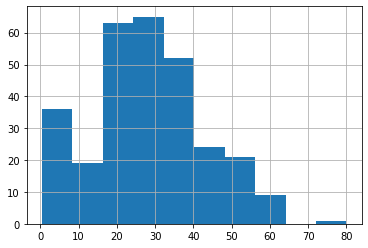

In [26]:
# Survivors Age
survivors_age = train_data.loc[train_data.Survived==1, 'Age']
survivors_age.hist()

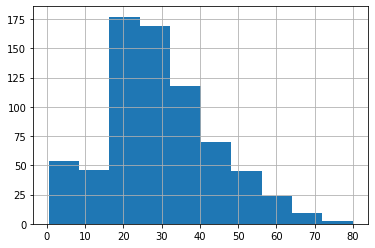

In [27]:
# Age Histogram
#plt.hist(train_data_pd["Age"])
train_data_pd["Age"].hist()

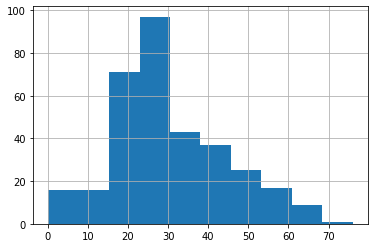

In [28]:
test_data_pd["Age"].hist()

In [29]:
known_age = train_data_pd.loc[~train_data.Age.isna()]
unknow_age = train_data_pd.loc[train_data.Age.isna()]

In [30]:
corr_matrix = known_age.corr()
corr_matrix["Age"].sort_values(ascending=False)

Age           1.000000
Fare          0.096067
Sex_male      0.093254
Embarked_C    0.036261
Embarked_Q   -0.022405
Embarked_S   -0.023233
Survived     -0.077221
Sex_female   -0.093254
Parch        -0.189119
SibSp        -0.308247
Pclass       -0.369226
Name: Age, dtype: float64

In [31]:
known_age.drop(columns=['Embarked_C','Embarked_Q','Embarked_S'], inplace=True)
unknow_age.drop(columns=['Embarked_C','Embarked_Q','Embarked_S'], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [32]:
from sklearn.linear_model import LinearRegression

# X_lin_train = train_data.loc[train_data.Survived==1]
# X_lin_pred = train_data.loc[train_data.Survived==0]

# lin_reg = LinearRegression()
# lin_reg.fit(housing_prepared, housing_labels)

In [33]:
# Create Age Categories
train_data_pd["Age_cat"] = pd.cut(x=train_data_pd["Age"], bins=[0., 9, 18, 32, 40, 62.,np.inf], labels=[1,2,3,4,5,6])
train_data_pd.drop(columns="Age",inplace=True)
train_data_pd

# Create Age Categories
test_data_pd["Age_cat"] = pd.cut(x=test_data_pd["Age"], bins=[0., 9, 18, 32, 40, 62.,np.inf], labels=[1,2,3,4,5,6])
test_data_pd.drop(columns="Age",inplace=True)
test_data_pd

,Pclass,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_cat
0,3,0,0,7.8292,0,1,0,1,0,4
1,3,1,0,7.0000,1,0,0,0,1,5
2,2,0,0,9.6875,0,1,0,1,0,5
3,3,0,0,8.6625,0,1,0,0,1,3
4,3,1,1,12.2875,1,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...
413,3,0,0,8.0500,0,1,0,0,1,NaN
414,1,0,0,108.9000,1,0,1,0,0,4
415,3,0,0,7.2500,0,1,0,0,1,4
416,3,0,0,8.0500,0,1,0,0,1,NaN


In [34]:
# from sklearn.impute import KNNImputer

# imp = KNNImputer(n_neighbors=3)
# train_data_array = imp.fit_transform(train_data_pd)
# train_data_pd = pd.DataFrame(train_data_array, columns=train_data_pd.columns, index=train_data_pd.index)
# train_data_pd["Age_cat"] = train_data_pd["Age_cat"].round()
# train_data_pd

# test_data_array = imp.fit_transform(test_data_pd)
# test_data_pd = pd.DataFrame(test_data_array, columns=test_data_pd.columns, index=test_data_pd.index)
# test_data_pd["Age_cat"] = test_data_pd["Age_cat"].round()
# test_data_pd

In [35]:
imp = IterativeImputer(max_iter=10, random_state=0)

imp.fit(train_data_pd)
train_data_array = imp.transform(train_data_pd)
train_data_pd = pd.DataFrame(train_data_array, columns=train_data_pd.columns, index=train_data_pd.index)
train_data_pd["Age_cat"] = train_data_pd["Age_cat"].round()
train_data_pd

imp.fit(test_data_pd)
test_data_array = imp.transform(test_data_pd)
test_data_pd = pd.DataFrame(test_data_array, columns=test_data_pd.columns, index=test_data_pd.index)
test_data_pd["Age_cat"] = test_data_pd["Age_cat"].round()
test_data_pd

,Pclass,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_cat
0,3.0,0.0,0.0,7.8292,0.0,1.0,0.0,1.0,0.0,4.0
1,3.0,1.0,0.0,7.0000,1.0,0.0,0.0,0.0,1.0,5.0
2,2.0,0.0,0.0,9.6875,0.0,1.0,0.0,1.0,0.0,5.0
3,3.0,0.0,0.0,8.6625,0.0,1.0,0.0,0.0,1.0,3.0
4,3.0,1.0,1.0,12.2875,1.0,0.0,0.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
413,3.0,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0,3.0
414,1.0,0.0,0.0,108.9000,1.0,0.0,1.0,0.0,0.0,4.0
415,3.0,0.0,0.0,7.2500,0.0,1.0,0.0,0.0,1.0,4.0
416,3.0,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0,3.0


In [36]:
# Drop Embarked
test_data_pd.drop(columns=['Fare','Embarked_C','Embarked_Q','Embarked_S'], inplace=True)
train_data_pd.drop(columns=['Fare','Embarked_C','Embarked_Q','Embarked_S'], inplace=True)
train_data_pd

,Survived,Pclass,SibSp,Parch,Sex_female,Sex_male,Age_cat
0,0.0,3.0,1.0,0.0,0.0,1.0,3.0
1,1.0,1.0,1.0,0.0,1.0,0.0,4.0
2,1.0,3.0,0.0,0.0,1.0,0.0,3.0
3,1.0,1.0,1.0,0.0,1.0,0.0,4.0
4,0.0,3.0,0.0,0.0,0.0,1.0,4.0
...,...,...,...,...,...,...,...
886,0.0,2.0,0.0,0.0,0.0,1.0,3.0
887,1.0,1.0,0.0,0.0,1.0,0.0,3.0
888,0.0,3.0,1.0,2.0,1.0,0.0,3.0
889,1.0,1.0,0.0,0.0,0.0,1.0,3.0


In [37]:
X = train_data_pd.drop(columns='Survived')
X_test = test_data_pd

# 3. My Model

**GridSearch Random Forest Model**

In [38]:
from sklearn.model_selection import GridSearchCV
# my_model = RandomForestClassifier()


# param_grid = [
#               {'n_estimators':[10,100,1000], 'max_features':[6], 'max_depth':[2,5,10],'random_state':[1]},
# ]

**Logistic Regression**

In [39]:
from sklearn.linear_model import LogisticRegression

# log_reg = LogisticRegression()
# # log_reg.fit(X,y)

# param_grid = [
#               {'tol':[0.0001,0.001,0.01], 'C':[0.1,1,10]},
# ]

# my_model = log_reg

**Support Vector Machine**

In [40]:
from sklearn.svm import SVC

svc_reg = SVC()

param_grid = [
              {'kernel':['linear'], 'C':[1.0, 10.0, 100.0, 1000.0]},
              {'kernel':['rbf'], 'C':[1.0, 10.0, 100.0, 1000.0], 'gamma':[0.01, 0.1, 1.0, 3.0]},
              {'kernel':['sigmoid'], 'C':[1.0, 10.0, 100.0, 1000.0], 'gamma':[0.01, 0.1, 1.0, 3.0]},
]

my_model = svc_reg

In [41]:
grid_search = GridSearchCV(estimator=my_model, 
                           param_grid=param_grid,
                           cv=5,
                           #scoring='accuracy',
                           scoring='f1',
                           return_train_score=True,
                           verbose=True)

grid_search.fit(X,y)
grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    9.9s finished


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [42]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(mean_score, params)

0.7092684925689026 {'C': 1.0, 'kernel': 'linear'}
0.7092684925689026 {'C': 10.0, 'kernel': 'linear'}
0.7092684925689026 {'C': 100.0, 'kernel': 'linear'}
0.7092684925689026 {'C': 1000.0, 'kernel': 'linear'}
0.7125964584626581 {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.7623499232416926 {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.7412402774352558 {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
0.7142413356670563 {'C': 1.0, 'gamma': 3.0, 'kernel': 'rbf'}
0.7208116123347811 {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.7515092301564354 {'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.7270655384768554 {'C': 10.0, 'gamma': 1.0, 'kernel': 'rbf'}
0.7186082876845887 {'C': 10.0, 'gamma': 3.0, 'kernel': 'rbf'}
0.7446067195986916 {'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.7192769363349821 {'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.7270655384768554 {'C': 100.0, 'gamma': 1.0, 'kernel': 'rbf'}
0.7186082876845887 {'C': 100.0, 'gamma': 3.0, 'kernel': 'rbf'}
0.7586612704103743 {'C': 1000.0, 'gamma': 0.01,

In [43]:
predictions = grid_search.best_estimator_.predict(X_test)

**Save Submissions**

In [44]:
SaveSubmission(predictions)

Your submission was successfully saved


# 4. Evaluate Best Model

**F1 Score**

In [45]:
my_model = grid_search.best_estimator_

In [46]:
predictions_X = my_model.predict(X)

f1_my_model = f1_score(y,predictions_X)
f1_my_model

0.7692307692307693

**Cross Validation Error**

In [47]:
scores_my_model = cross_val_score(my_model, X, y, scoring="f1", cv=5)

display_scores(scores_my_model)

Scores [0.7761194  0.76335878 0.76335878 0.70588235 0.8030303 ]
Mean 0.7623499232416926
Standard Deviation 0.031733622378056464


In [48]:
scores_my_model = cross_val_score(my_model, X, y, scoring="accuracy", cv=5)

display_scores(scores_my_model)

Scores [0.83240223 0.8258427  0.8258427  0.80337079 0.85393258]
Mean 0.8282781997363632
Standard Deviation 0.016170328962023472
